# MLIKH Model: Creep Response

## Learning Objectives

1. Fit **MLIKH** to creep data (constant stress, measure strain)
2. Analyze **multi-mode delayed yielding** behavior
3. Observe how distributed thixotropic timescales affect creep
4. Compare with single-mode MIKH predictions

## Prerequisites

- NB04: MIKH Creep (single-mode understanding)
- NB07: MLIKH Flow Curve (multi-mode basics)

## Runtime

- Fast demo: ~4-5 minutes
- Full run: ~15-18 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ml_ikh_creep,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3


81

## 2. Theory: Multi-Mode Creep

In MLIKH creep:
- Each mode can yield at different times
- Structure evolution for each mode: $\lambda_i(t)$
- Total strain accumulates from all mode contributions

### Delayed Yielding with Multiple Modes

With distributed thixotropic timescales:
- Fast modes yield first (small $\tau_{thix,i}$)
- Slow modes yield later (large $\tau_{thix,i}$)
- Creates stepped or gradual acceleration

## 3. Load Data

In [3]:
# Load creep data (step stress tests)
creep_datasets = {}

for idx in range(3):
    t, gamma_dot, sigma_i, sigma_f = load_ml_ikh_creep(stress_pair_index=idx)
    creep_datasets[(sigma_i, sigma_f)] = {
        "time": t,
        "shear_rate": gamma_dot,
        "initial_stress": sigma_i,
        "final_stress": sigma_f,
    }
    print(f"Stress: {sigma_i:.0f} -> {sigma_f:.0f} Pa, {len(t)} points")

Stress: 3 -> 5 Pa, 70 points
Stress: 3 -> 7 Pa, 70 points
Stress: 3 -> 9 Pa, 70 points


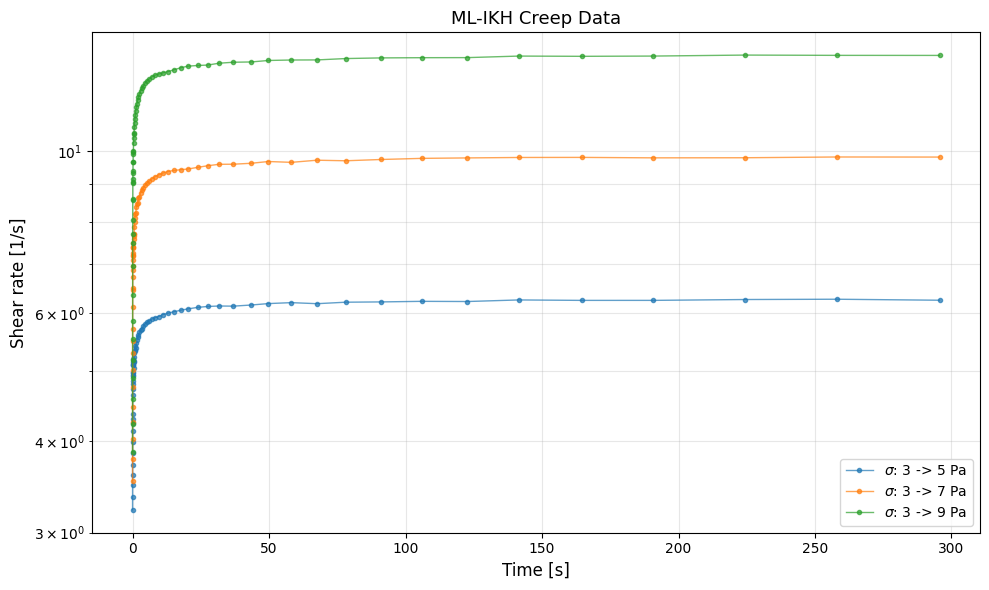

In [4]:
# Plot creep data
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["C0", "C1", "C2"]

for i, (key, d) in enumerate(creep_datasets.items()):
    sigma_i, sigma_f = key
    ax.semilogy(d["time"], d["shear_rate"], "o-", color=colors[i],
                markersize=3, lw=1, alpha=0.7,
                label=f"$\\sigma$: {sigma_i:.0f} -> {sigma_f:.0f} Pa")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Shear rate [1/s]", fontsize=12)
ax.set_title("ML-IKH Creep Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Select reference dataset
ref_key = (3.0, 7.0)
d = creep_datasets[ref_key]
t_data = d["time"]
gamma_dot_data = d["shear_rate"]
sigma_applied = d["final_stress"]

# Create and fit model
n_modes = 2
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

print(f"Fitting MLIKH ({n_modes} modes) to creep at sigma = {sigma_applied} Pa")
t0 = time.time()
model.fit(t_data, gamma_dot_data, test_mode="creep", sigma_applied=sigma_applied, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")

Fitting MLIKH (2 modes) to creep at sigma = 7.0 Pa


NLSQ fit time: 39.31 s


In [6]:
# Predict and compute fit quality
gamma_pred = model.predict(t_data, test_mode="creep", sigma_applied=sigma_applied)
gamma_dot_pred = np.gradient(np.array(gamma_pred), np.array(t_data))

metrics = compute_fit_quality(gamma_dot_data, gamma_dot_pred)
print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} 1/s")


Fit Quality:
  R^2:   -21.499068
  RMSE:  8.194 1/s


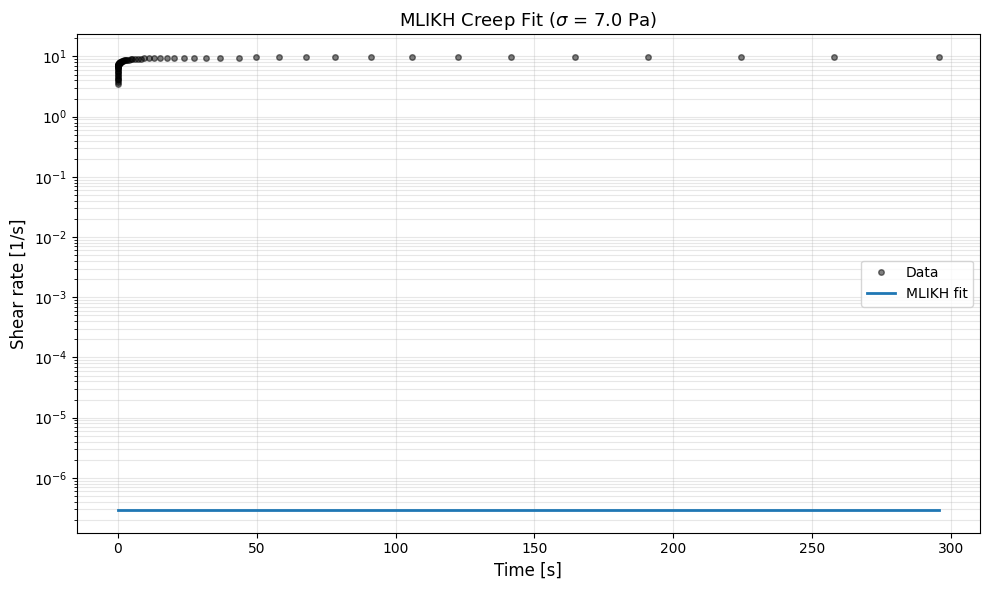

In [7]:
# Plot fit
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogy(t_data, gamma_dot_data, "ko", markersize=4, alpha=0.5, label="Data")
ax.semilogy(t_data, np.abs(gamma_dot_pred), "-", lw=2, color="C0", label="MLIKH fit")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Shear rate [1/s]", fontsize=12)
ax.set_title(f"MLIKH Creep Fit ($\\sigma$ = {sigma_applied} Pa)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

In [8]:
# Clear JAX compilation caches before Bayesian inference to reduce peak memory
import gc
gc.collect()
try:
    jax.clear_caches()
except Exception:
    pass

# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    gamma_dot_data,
    test_mode="creep",
    sigma_applied=sigma_applied,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:03<08:19,  3.35s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  13%|█▎        | 19/150 [00:03<00:17,  7.48it/s, 255 steps of size 1.80e-02. acc. prob=0.79]

warmup:  17%|█▋        | 26/150 [00:03<00:12, 10.03it/s, 63 steps of size 1.12e-01. acc. prob=0.84] 

warmup:  21%|██        | 31/150 [00:03<00:09, 12.53it/s, 127 steps of size 4.85e-02. acc. prob=0.84]

warmup:  24%|██▍       | 36/150 [00:03<00:07, 15.74it/s, 63 steps of size 5.71e-02. acc. prob=0.84] 

warmup:  27%|██▋       | 41/150 [00:04<00:05, 18.58it/s, 127 steps of size 1.02e-01. acc. prob=0.86]

warmup:  31%|███       | 46/150 [00:04<00:04, 21.24it/s, 31 steps of size 5.54e-01. acc. prob=0.85] 

sample:  44%|████▍     | 66/150 [00:04<00:01, 47.60it/s, 7 steps of size 9.29e-02. acc. prob=0.78] 

sample:  63%|██████▎   | 94/150 [00:04<00:00, 87.55it/s, 15 steps of size 9.29e-02. acc. prob=0.81]

sample:  80%|████████  | 120/150 [00:04<00:00, 121.27it/s, 7 steps of size 9.29e-02. acc. prob=0.85]

sample:  97%|█████████▋| 146/150 [00:04<00:00, 151.72it/s, 15 steps of size 9.29e-02. acc. prob=0.85]

sample: 100%|██████████| 150/150 [00:04<00:00, 31.95it/s, 15 steps of size 9.29e-02. acc. prob=0.84] 


Bayesian inference time: 10.4 s


In [9]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    0.9924       121      PASS
            C_1    0.9900       238      PASS
    gamma_dyn_1    1.0105        49     CHECK
     sigma_y0_1    0.9944       421      PASS
delta_sigma_y_1    0.9900       186      PASS
     tau_thix_1    1.0088       198      PASS
        Gamma_1    1.0057        88     CHECK
            G_2    0.9954       141      PASS
            C_2    0.9905       209      PASS
    gamma_dyn_2    1.0087       103      PASS
     sigma_y0_2    0.9901       184      PASS
delta_sigma_y_2    0.9912       117      PASS
     tau_thix_2    0.9920       119      PASS
        Gamma_2    0.9901       113      PASS
        eta_inf    1.0323        28     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


## 6. Physical Interpretation

### Multi-Mode Delayed Yielding

With multiple modes, the yielding transition can be:
- **Gradual**: Modes yield sequentially as their structure breaks down
- **Stepped**: Distinct jumps when each mode yields
- **Smooth**: Overlapping mode contributions create continuous transition

### Mode-Specific Structure Evolution

Each mode evolves independently:
$$
\frac{d\lambda_i}{dt} = \frac{1 - \lambda_i}{\tau_{thix,i}} - \Gamma_i \lambda_i |\dot{\gamma}^p|
$$

## 7. Save Results

In [10]:
# Save results
save_ikh_results(model, result, "mlikh", "creep", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/creep/
  nlsq_params_creep.json: 15 parameters
  posterior_creep.json: 100 draws


## Key Takeaways

1. **Multi-mode creep** captures distributed restructuring timescales
2. **Delayed yielding** can show gradual or stepped transitions
3. **Mode-specific structure** ($\lambda_i$) evolves independently
4. **Viscosity bifurcation** affected by all mode contributions

### Next Steps

- **NB11**: MLIKH SAOS (broadened spectra)
- **NB12**: MLIKH LAOS

In [11]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
